#**1. Introduction & Business Context**

### **Latar Belakang:**
*Pertumbuhan penggunaan aplikasi e-wallet di Indonesia menghasilkan volume ulasan pengguna yang besar dan bersifat tidak terstruktur. Ulasan ini mencerminkan pengalaman pengguna terkait berbagai aspek layanan, seperti kegagalan transaksi, stabilitas sistem, keamanan akun, serta efektivitas program promo. Analisis manual terhadap data teks dalam skala besar menjadi tidak efisien, sehingga diperlukan pendekatan berbasis Natural Language Processing (NLP) dan machine learning.*

### Tujuan Project:
*Project ini bertujuan untuk melakukan segmentasi perilaku pengguna e-wallet dengan mengombinasikan analisis sentimen dan topic modeling. Hasil analisis digunakan untuk mengelompokkan pengguna ke dalam beberapa cluster, seperti pengguna yang mengalami kegagalan transaksi (*transaction-failure users*), pengguna yang sensitif terhadap promo (*promo-driven users*), serta pengguna dengan perhatian tinggi terhadap aspek keamanan (*security-concerned users*).*

# **2. Library & Dependencies**

In [2]:
!pip install sastrawi

!pip install google-play-scraper pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00


In [3]:
# ================================
# Core Libraries
# ================================
import numpy as np
import pandas as pd
import re
import string
from tqdm import tqdm
from google_play_scraper import reviews, Sort

# ================================
# Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# NLP - Bahasa Indonesia
# ================================
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# ================================
# Text Vectorization & Modeling
# ================================
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
)

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation

# ================================
# Machine Learning Utilities
# ================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ================================
# Evaluation & Metrics
# ================================
from sklearn.metrics import silhouette_score

# **3. Data Acquisition (Web Scraping)**

In [4]:
def scrape_reviews_2025_2026(app_id: str, n_reviews: int = 10000) -> pd.DataFrame:
    all_reviews = []
    continuation_token = None

    with tqdm(total=n_reviews, desc="Scraping Reviews") as pbar:
        while len(all_reviews) < n_reviews:
            result, continuation_token = reviews(
                app_id=app_id,
                lang='id',
                country='id',
                sort=Sort.MOST_RELEVANT,  # ⬅️ PENTING
                count=200,
                continuation_token=continuation_token
            )

            if not result:
                break

            all_reviews.extend(result)
            pbar.update(len(result))

            if continuation_token is None:
                break

    df = pd.DataFrame(all_reviews)

    df = df[['content', 'score', 'at', 'reviewCreatedVersion']].rename(columns={
        'content': 'review',
        'score': 'rating',
        'at': 'date',
        'reviewCreatedVersion': 'app_version'
    })

    # Bersihkan data
    df = df[df['review'].notna()]
    df = df[df['review'].str.strip() != ""]
    df.drop_duplicates(subset='review', inplace=True)

    # Konversi tanggal
    df['date'] = pd.to_datetime(df['date'])

    # 🔴 FILTER TAHUN 2025–2026
    df = df[
        (df['date'].dt.year >= 2025) &
        (df['date'].dt.year <= 2026)
    ]

    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
df_dana = scrape_reviews_2025_2026("id.dana", 10000)
df_dana.to_csv("dana_reviews_raw.csv", index=False)

print(df_dana['date'].dt.year.value_counts())
print("Total data:", len(df_dana))

Scraping Reviews: 100%|██████████| 10000/10000 [00:15<00:00, 637.89it/s]


date
2025    8730
2026    1270
Name: count, dtype: int64
Total data: 10000


# **4. Data Understanding & Initial Exploration**

## **4.1 Load Data & Overview**

In [6]:
df = pd.read_csv("dana_reviews_raw.csv")

display(
    df.head(5).style
    .set_table_styles([
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '12pt'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('color', '#2f2f2f')
        ]},
        {'selector': 'th', 'props': [
            ('background-color', '#d9d9d9'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('border', '1px solid #444444'),
            ('color', '#1a1a1a')
        ]},
        {'selector': 'td', 'props': [
            ('background-color', '#f0f0f0'),
            ('border', '1px solid #444444'),
            ('vertical-align', 'top'),
            ('white-space', 'pre-wrap'),
            ('font-size', '11pt'),
            ('color', '#1a1a1a')
        ]}
    ])
)

,review,rating,date,app_version
0,"Alhamdulillah, setelah 1 thn ndak bisa log in ternyata saldo masih aman🥲 lain kali kalau seandainya mau ganti nomor tapi nomor lama hilang tolong di permudah verifikasi nya, misal kirim otp lewat Gmail yang tertaut di akun dana, jangan hanya lewat nomor yang terdaftar saja, bisa di tingkatkan lagi. Dan lagi, kenapa 2 akun dana semua premium satunya bisa berjalan normal satunya layar putih ketika melihat riwayat? Paket internet dari operator yang sama, jadi saya rasa bukan masalah sinyal",4,2026-01-11 02:37:25,2.109.2
1,hilang saldo'.dan tidak ada respon untuk pengembalian...di karenakan tidak membeli X-tra protection yang tertulis sebagai alat untuk lebih meningkatkan informasi data dan memberikan kompensasi terhadap adanya penipuan'atau pembobolan...sangat mengecewakan. . . sudah hilang saldo tidak balik malah di suruh membeli X-tra protection.... kurang puas atas layanan...masih kalah sama aplikasi yang lain ada komplenan dari nasabah cepat dan membantu.....yang mau mencoba simpan uang/transaksi di pikir2,2,2026-01-09 00:35:47,2.109.2
2,"dana goals saya tidak bisa di tarik dari 3 hari lalu, gak kya biasanya mah ini, kecewa banget, langkah""sudah saya lakukan semua gak ada yang berubah masih sama, kirim screnshot ke diana juga gak bisa baca gambar katanya, terus saya sudah kirim screnshot ke dm instagram, ke email juga masih belum di tanggapi, penanganannya lambat sekali.",1,2026-01-08 12:07:39,2.109.2
3,"Aplikasi ini cukup membantu, terutama saat butuh dana mendesak. Proses aplikasi cepat, hanya perlu KTP saja, dan pencairannya lumayan cepat. Namun, bunganya agak lebih tinggi dibandingkan beberapa platform lain. Pembayaran tagihan juga mudah karena ada banyak pilihan kanal pembayaran. Semoga ke depannya lebih transparan soal biaya tambahan. Secara keseluruhan, cukup memuaskan untuk situasi darurat.",5,2026-01-04 09:57:04,2.109.2
4,"""Aplikasi ini jelek untuk menyelesaikan problem lambat sekali, saya ini kan buka akun baru, lalu saya top up tujuannya untuk krim uang ke adik pas tahun baru, eh malah tidak bisa krena alasan upgrade, mau di upgrade katanya ada akun yang lama, mau hpus akun yang lama malah tidak bisa, prosesnya seperti tidak jalan mana AI Diana itu jelek sekali penanganannya.",1,2026-01-01 04:19:34,2.109.2


In [7]:
print("="*60)
print("RINGKASAN DATASET ULASAN APLIKASI DANA")
print("="*60)

print(f"Jumlah total ulasan       : {len(df):,} data")
print(f"Jumlah kolom              : {df.shape[1]} kolom")
print()

print("Nama Kolom dan Tipe Data")
print("-"*60)
for col, dtype in df.dtypes.items():
    print(f"{col:<20} : {dtype}")

print()

print("Jumlah Data Kosong (Missing Values)")
print("-"*60)
print(df.isnull().sum())

print()

print("Contoh Statistik Rating")
print("-"*60)
print(df['rating'].describe())

print("="*60)

RINGKASAN DATASET ULASAN APLIKASI DANA
Jumlah total ulasan       : 10,000 data
Jumlah kolom              : 4 kolom

Nama Kolom dan Tipe Data
------------------------------------------------------------
review               : object
rating               : int64
date                 : object
app_version          : object

Jumlah Data Kosong (Missing Values)
------------------------------------------------------------
review          0
rating          0
date            0
app_version    13
dtype: int64

Contoh Statistik Rating
------------------------------------------------------------
count    10000.000000
mean         2.528700
std          1.712387
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


## **4.2 Distribusi Rating**

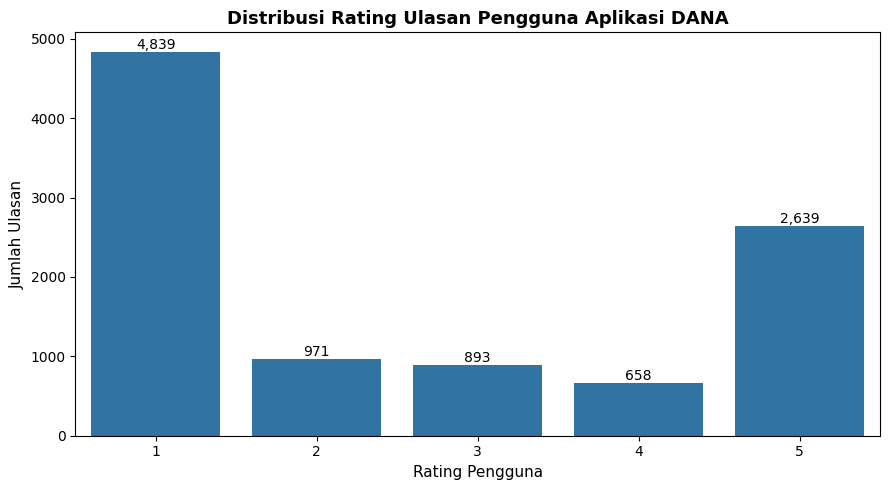

In [8]:
plt.figure(figsize=(9, 5))

ax = sns.countplot(
    x='rating',
    data=df,
    order=sorted(df['rating'].unique())
)

plt.title("Distribusi Rating Ulasan Pengguna Aplikasi DANA", fontsize=13, fontweight='bold')
plt.xlabel("Rating Pengguna", fontsize=11)
plt.ylabel("Jumlah Ulasan", fontsize=11)

# Tambahkan label jumlah di atas setiap bar
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

## **4.3 Panjang Review (Karakter & Kata)**

**Kode Pengolahan Panjang Review**

In [9]:
# Panjang review dalam karakter
df['review_length_char'] = df['review'].astype(str).apply(len)

# Panjang review dalam jumlah kata
df['review_length_word'] = df['review'].astype(str).apply(lambda x: len(x.split()))

**Visualisasi Distribusi Panjang Review (Jumlah Kata)**

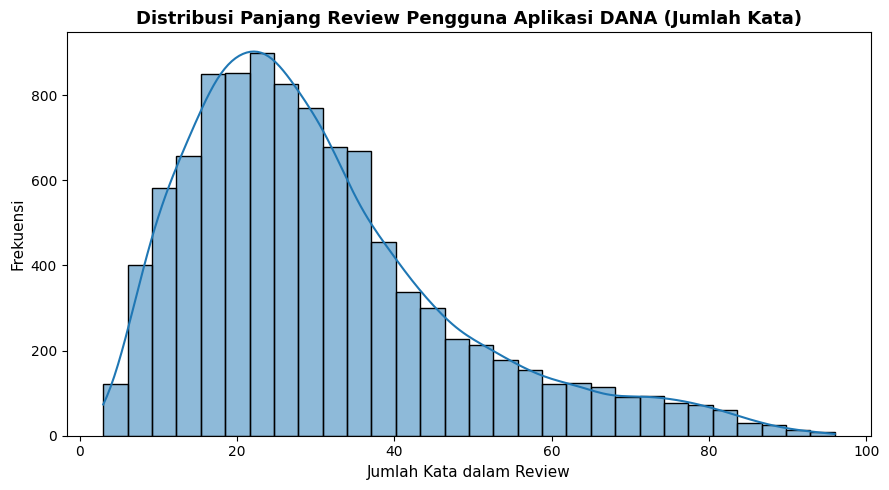

In [10]:
plt.figure(figsize=(9, 5))

ax = sns.histplot(
    df['review_length_word'],
    bins=30,
    kde=True
)

plt.title(
    "Distribusi Panjang Review Pengguna Aplikasi DANA (Jumlah Kata)",
    fontsize=13,
    fontweight='bold'
)
plt.xlabel("Jumlah Kata dalam Review", fontsize=11)
plt.ylabel("Frekuensi", fontsize=11)

plt.tight_layout()
plt.show()

## **4.4 Review Berdasarkan Waktu**

**Pengolahan Data Waktu**

In [11]:
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')

review_time = df.groupby('year_month').size()

**Visualisasi Jumlah Review per Bulan**

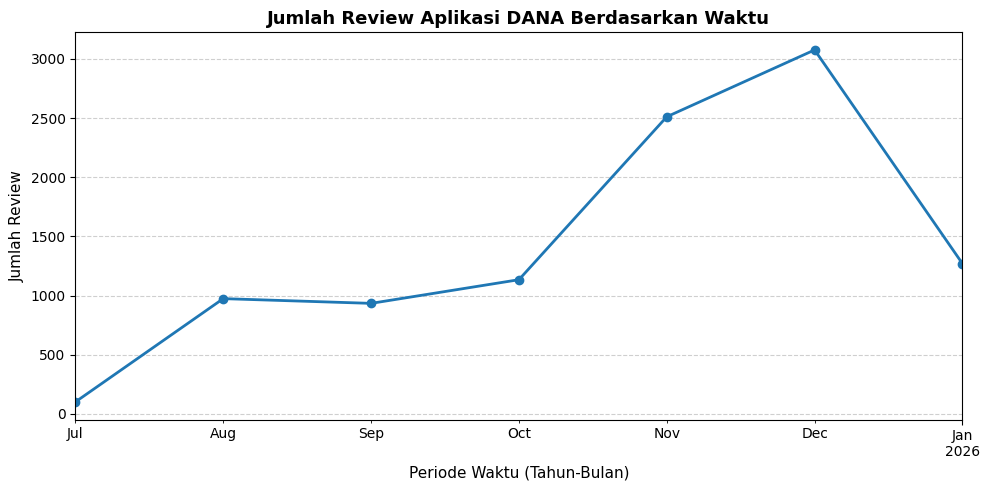

In [12]:
plt.figure(figsize=(10, 5))

if len(review_time) == 1:
    review_time.plot(
        kind='bar',
        width=0.4
    )
else:
    review_time.plot(
        marker='o',
        linewidth=2
    )

plt.title(
    "Jumlah Review Aplikasi DANA Berdasarkan Waktu",
    fontsize=13,
    fontweight='bold'
)
plt.xlabel("Periode Waktu (Tahun-Bulan)", fontsize=11)
plt.ylabel("Jumlah Review", fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# **5. Text Preprocessing (Bahasa Indonesia)**

## **5.2 Inisialisasi Stemmer & Stopword**

In [13]:
stemmer = StemmerFactory().create_stemmer()
stopwords = set(StopWordRemoverFactory().get_stop_words())

## **5.3Fungsi Preprocessing (Clean Code)**

In [14]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = text.lower()                               # case folding
    text = re.sub(r"http\S+", "", text)               # remove URL
    text = re.sub(r"\d+", "", text)                   # remove angka
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    tokens = [stemmer.stem(t) for t in tokens]

    return " ".join(tokens)

## **5.4 Apply Preprocessing**

In [15]:
df['clean_text'] = df['review'].apply(clean_text)
df[['review', 'clean_text']].head()

,review,clean_text
0,"Alhamdulillah, setelah 1 thn ndak bisa log in ...",alhamdulillah thn ndak log nyata saldo aman ka...
1,hilang saldo'.dan tidak ada respon untuk penge...,hilang saldodan respon pengembaliandi karena b...
2,dana goals saya tidak bisa di tarik dari 3 har...,dana goals tarik hari lalu gak kya biasa mah k...
3,"Aplikasi ini cukup membantu, terutama saat but...",aplikasi cukup bantu utama butuh dana desak pr...
4,"""Aplikasi ini jelek untuk menyelesaikan proble...",aplikasi jelek selesai problem lambat sekali k...


# **6. Sentiment Analysis**

## **6.1 Label Sentimen (Rule-Based dari Rating)**

In [16]:
def rating_to_sentiment(r):
    if r <= 2:
        return 0   # negative
    elif r == 3:
        return 1   # neutral
    else:
        return 2   # positive

df['sentiment_label'] = df['rating'].apply(rating_to_sentiment)

##**6.2 TF-IDF Vectorization**

In [17]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['sentiment_label']

##**6.3 Logistic Regression**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## **6.4 Sentiment Score Numerik**

In [19]:
sentiment_proba = model.predict_proba(X_tfidf)

df['sentiment_score'] = (
    sentiment_proba[:,2] - sentiment_proba[:,0]
)

## **6.5 Visual Distribusi Sentimen**

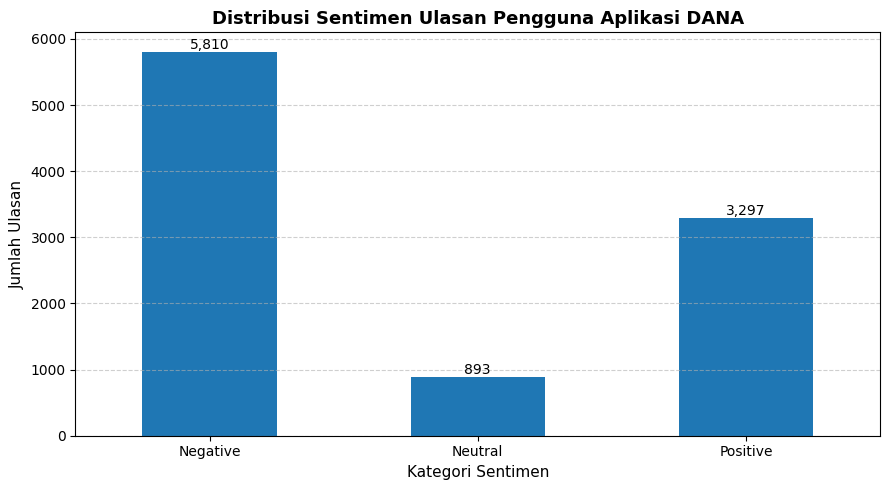

In [20]:
# Hitung distribusi sentimen
sentiment_counts = df['sentiment_label'].value_counts().sort_index()

plt.figure(figsize=(9, 5))

ax = sentiment_counts.plot(
    kind='bar',
    width=0.5
)

# Judul dan label
plt.title(
    "Distribusi Sentimen Ulasan Pengguna Aplikasi DANA",
    fontsize=13,
    fontweight='bold'
)
plt.xlabel("Kategori Sentimen", fontsize=11)
plt.ylabel("Jumlah Ulasan", fontsize=11)

# Atur label sumbu X
plt.xticks(
    ticks=[0, 1, 2],
    labels=['Negative', 'Neutral', 'Positive'],
    rotation=0
)

# Tambahkan angka di atas batang
for i, v in enumerate(sentiment_counts.values):
    ax.text(
        i,
        v,
        f"{v:,}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Grid halus agar mudah dibaca
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# **7. Topic Modeling (LDA)**

## **7.1 Document-Term Matrix**

In [21]:
cv = CountVectorizer(
    max_df=0.9,
    min_df=10,
    ngram_range=(1,2)
)

X_dtm = cv.fit_transform(df['clean_text'])

## **7.2 Training LDA**

In [22]:
n_topics = 6

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch'
)

topic_distribution = lda.fit_transform(X_dtm)

## **7.3 Interpretasi Topik**

In [23]:
def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        print(f"Topik {idx}: {', '.join(words)}")

display_topics(lda, cv.get_feature_names_out())

Topik 0: akun, dana, nomor, otp, nya, kode, login, masuk, verifikasi, akun dana
Topik 1: dana, gak, mau, udah, nya, aja, malah, update, aplikasi, buka
Topik 2: dana, cicil, dana cicil, fitur, nya, guna, fitur dana, gak, transaksi, padahal
Topik 3: sangat, aplikasi, dana, mudah, bagus, transaksi, bantu, nya, guna, bayar
Topik 4: premium, upgrade, mau, uang, kirim, padahal, tarik, dana, suruh, malah
Topik 5: dana, saldo, aplikasi, uang, tiba, transaksi, hilang, masuk, potong, nya


# **8. Feature Engineering (Final Matrix)**

In [24]:
features = pd.concat([
    pd.DataFrame(topic_distribution, columns=[f'topic_{i}' for i in range(n_topics)]),
    df[['sentiment_score', 'rating', 'review_length_word']]
], axis=1)

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# **9. Clustering — K-Means**

## **9.1 Elbow Method**

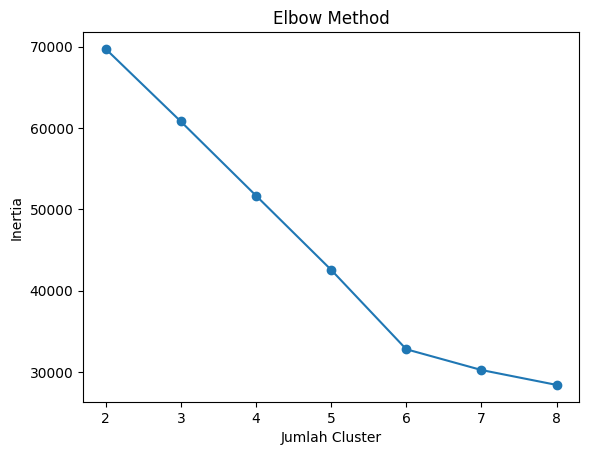

In [26]:
inertia = []
K = range(2,9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

## **9.2 Final Clustering**

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# **10. Cluster Interpretation**

In [28]:
cluster_summary = df.groupby('cluster').agg({
    'rating':'mean',
    'sentiment_score':'mean',
    'review':'count'
}).rename(columns={'review':'jumlah_review'})

cluster_summary

,rating,sentiment_score,jumlah_review
cluster,,,
0,1.828436,-0.533873,5683
1,4.623001,0.609149,1626
2,2.235732,-0.390932,1209
3,3.155196,-0.008165,1482


In [29]:
for c in sorted(df['cluster'].unique()):
    print(f"\n===== CLUSTER {c} =====")
    print(df[df['cluster']==c]['review'].head(3).to_string(index=False))


===== CLUSTER 0 =====
Alhamdulillah, setelah 1 thn ndak bisa log in t...
hilang saldo'.dan tidak ada respon untuk pengem...
dana goals saya tidak bisa di tarik dari 3 hari...

===== CLUSTER 1 =====
Aplikasi ini cukup membantu, terutama saat butu...
Aplikasi ini lumayan membantu untuk kebutuhan m...
Aplikasi yang sangat praktis dan mudah digunaka...

===== CLUSTER 2 =====
setelah diupdate tidak bisa transfer,hanya load...
ga bisa kirim uang. verif via sms tidak masuk. ...
aku kasih bintang dua karena 1. aplikasinya ber...

===== CLUSTER 3 =====
Sudah 1 bulan lebih fitur dana cicil sy msh blm...
kasih bintang 4 dulu deh, soalnya fitur semacam...
sejauh ini bagus, ga ada bug atau apapun itu, s...
